In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [2]:
corder = ['C1', 'C2', 'C3', 'C4', 'C0']

In [3]:
morder = ['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS',]
media_order = ['lowN', 'pro99']
mpalette = 'twilight'
sns.color_palette(mpalette, n_colors=5)

[(0.4828677867260272, 0.6304330455306234, 0.761915371498953),
 (0.3668108554010799, 0.26404857724525643, 0.6464799165290824),
 (0.18488035509396164, 0.07942573027972388, 0.21307651648984993),
 (0.5566322903496934, 0.17269677158182117, 0.31423043195101424),
 (0.775907907306857, 0.5355421788246119, 0.42413367909988375)]

In [4]:
gorder = [ 'Strong', 'Sustained', 'Weak', 'Inhibited','Axenic', 'Other']
gpalette = sns.color_palette('Set2', n_colors=4).as_hex() + ['black', 'lightgrey']
sns.color_palette(gpalette)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.0, 0.0, 0.0),
 (0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

In [5]:
df_predicted_classes = pd.read_csv('monte_predicted_classes.csv.gz')

In [6]:
df_predicted_classes.columns
# ['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model','hash']

Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
       'hash'],
      dtype='object')

In [7]:
dpath = '../results'
sim_df1 = pd.read_csv(os.path.join(dpath,'monte_het_clean_mse.csv.gz',))
#sim_df2 = pd.read_csv(os.path.join(dpath,'monte2_het_mse.csv.gz',))
mse_df =     sim_df1

# mse_df = pd.concat([
#     sim_df1,
#     sim_df2,
# ])

In [8]:
mse_df.head()

,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,run_id
0,0,10A0,Marinovum 5F3,Weak,4.779198,36.664228,74.0,175.225610,monte_OVERFLOW_33_monte_vpro_40_8_OVERFLOW_C2_...
1,1,10B0,Marinovum 5F3,Weak,4.925896,38.337364,74.0,188.845875,monte_OVERFLOW_33_monte_vpro_40_8_OVERFLOW_C2_...
2,2,10C0,Marinovum 5F3,Weak,1.482058,17.052662,74.0,25.273027,monte_OVERFLOW_33_monte_vpro_40_8_OVERFLOW_C2_...
3,3,11A0,Roseovarius 5C3,Weak,2.231368,19.121160,74.0,42.666345,monte_OVERFLOW_33_monte_vpro_40_8_OVERFLOW_C2_...
4,4,11B0,Roseovarius 5C3,Weak,3.720327,27.987097,74.0,104.121150,monte_OVERFLOW_33_monte_vpro_40_8_OVERFLOW_C2_...


In [9]:
mse_df = mse_df.reset_index(drop=True)

In [10]:
min_mse_df = mse_df.loc[mse_df.groupby('run_id')['RMSE'].idxmin()]

In [11]:
min_mse_df['model'] = min_mse_df.run_id.str.split('_', expand=True)[1]

In [12]:
min_mse_df['VPRO'] = min_mse_df.run_id.str.replace(r'.*(vpro.*_C[0-9])_.*',r'\1', regex=True)

In [13]:
min_mse_df['VPRO_cluster'] = min_mse_df.run_id.str.replace(r'.*_(C[0-9])_.*',r'\1', regex=True)

In [14]:
del mse_df

In [15]:
df = pd.merge(df_predicted_classes, min_mse_df, on=['run_id', 'model'], how='left')

In [16]:
df.columns

Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
       'hash', 'Unnamed: 0', 'Sample', 'full name', 'Group', 'RMSE_Bptotal[N]',
       'RMSE_Bptotal[C]', 'compare_points', 'RMSE', 'VPRO', 'VPRO_cluster'],
      dtype='object')

In [17]:
min_mse_df['run_id'].value_counts()

monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME_C1_29_lowN_all_EXOENZYME_h8519271514136708373    1
monte_OVERFLOW_40_monte_vpro_32_34_OVERFLOW_C4_37_lowN_all_OVERFLOW_h6878164821315599434        1
monte_OVERFLOW_3_monte_vpro_54_18_OVERFLOW_C1_46_lowN_all_OVERFLOW_h6878164821315599434         1
monte_OVERFLOW_3_monte_vpro_54_18_OVERFLOW_C1_9_lowN_all_OVERFLOW_h6878164821315599434          1
monte_OVERFLOW_3_monte_vpro_58_48_OVERFLOW_C2_22_lowN_all_OVERFLOW_h6878164821315599434         1
                                                                                               ..
monte_MIN_6_monte_vpro_90_35_MIN_C2_96_lowN_all_MIN_h-1541717058758371284                       1
monte_MIN_6_monte_vpro_90_91_MIN_C2_26_lowN_all_MIN_h-1541717058758371284                       1
monte_MIN_6_monte_vpro_90_91_MIN_C2_90_lowN_all_MIN_h-1541717058758371284                       1
monte_MIN_6_monte_vpro_92_40_MIN_C1_56_lowN_all_MIN_h-1541717058758371284                       1
monte_ROS_9_monte_vp

In [18]:
#df_predicted_classes.shape, 
min_mse_df.shape, df.shape

((49349, 12), (49349, 18))

In [19]:
df.head()

,run_id,y_pred,max_prob,idx,media,which,model,hash,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,VPRO,VPRO_cluster
0,monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME...,Sustained,0.977369,monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,1369253,10C0,Marinovum 5F3,Weak,4.328551,45.455198,74.0,196.755133,vpro_11_62_EXOENZYME_C1,C1
1,monte_EXOENZYME_100_monte_vpro_12_88_EXOENZYME...,Weak,0.928079,monte_EXOENZYME_100_monte_vpro_12_88_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,187008,11A0,Roseovarius 5C3,Weak,4.621448,30.284159,74.0,139.956662,vpro_12_88_EXOENZYME_C2,C2
2,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,Axenic,0.986109,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,lowN,all,EXOENZYME,h8519271514136708373,89707,1B0,Axenic,Axenic,2.342476,52.057268,74.0,121.942887,vpro_13_4_EXOENZYME_C3,C3
3,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,Axenic,0.986268,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,lowN,all,EXOENZYME,h8519271514136708373,738550,1B0,Axenic,Axenic,2.137782,47.880754,74.0,102.358629,vpro_13_4_EXOENZYME_C3,C3
4,monte_EXOENZYME_100_monte_vpro_13_69_EXOENZYME...,Axenic,0.972777,monte_EXOENZYME_100_monte_vpro_13_69_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,450721,7B0,Sulfitobacter pseudonitzschiae,Sustained,2.548766,24.861325,74.0,63.365700,vpro_13_69_EXOENZYME_C1,C1


In [20]:
problematic_ids =  df.loc[df.compare_points != 74, 'run_id']
problematic_ids

Series([], Name: run_id, dtype: object)

In [21]:
df = df.loc[~df.run_id.isin(problematic_ids)].copy()

In [22]:
df['RMSE'] = np.sqrt(df['RMSE'])

In [23]:
df.shape

(49349, 18)

In [24]:
df[['Group']].value_counts().reset_index()

,Group,0
0,Weak,27074
1,Axenic,18394
2,Sustained,3472
3,Strong,397
4,Inhibited,12


In [25]:
df[['Group']].value_counts() / 493.49

Group    
Weak         54.862307
Axenic       37.273298
Sustained     7.035604
Strong        0.804474
Inhibited     0.024317
dtype: float64

In [26]:
12/49349

0.00024316602160124825

In [27]:
df[['Group','model']].value_counts().reset_index()

,Group,model,0
0,Weak,ROS,6570
1,Weak,MIN,6288
2,Weak,OVERFLOW,6195
3,Axenic,EXOENZYME,6012
4,Weak,MIXOTROPH,5132
5,Axenic,MIXOTROPH,3444
6,Axenic,OVERFLOW,3159
7,Axenic,ROS,3008
8,Weak,EXOENZYME,2889
9,Axenic,MIN,2771


In [28]:
df['full name'].value_counts()

Axenic                            18394
Marinovum 5F3                     16083
Roseovarius 5C3                   10991
Sulfitobacter pseudonitzschiae     3294
A. macleodii ATCC27126              217
Pseudoalteromonas haloplanktis      180
Ruegeria pomeroyi                   178
Phaeobacter gallaeciensis            12
Name: full name, dtype: int64

In [29]:
df['RMSE'].describe()

count    49349.000000
mean        13.224055
std          6.664123
min          0.896181
25%          9.148062
50%         12.122113
75%         15.845451
max         76.875352
Name: RMSE, dtype: float64

In [30]:
df.nlargest(10, 'RMSE')

,run_id,y_pred,max_prob,idx,media,which,model,hash,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,VPRO,VPRO_cluster
44913,monte_ROS_5_monte_vpro_19_33_ROS_C0_70_lowN_al...,Strong,0.989043,monte_ROS_5_monte_vpro_19_33_ROS_C0_70,lowN,all,ROS,h-8660846992299669535,99399,5x5_21A0,A. macleodii ATCC27126,Strong,22.790988,259.305117,74.0,76.875352,vpro_19_33_ROS_C0,C0
47769,monte_ROS_86_monte_vpro_19_33_ROS_C0_32_lowN_a...,Strong,0.989042,monte_ROS_86_monte_vpro_19_33_ROS_C0_32,lowN,all,ROS,h-8660846992299669535,224199,5x5_21A0,A. macleodii ATCC27126,Strong,22.412984,255.662160,74.0,75.697766,vpro_19_33_ROS_C0,C0
39779,monte_ROS_12_monte_vpro_19_33_ROS_C0_16_lowN_a...,Strong,0.989041,monte_ROS_12_monte_vpro_19_33_ROS_C0_16,lowN,all,ROS,h-8660846992299669535,451374,5x5_21A0,A. macleodii ATCC27126,Strong,22.176763,252.233695,74.0,74.791223,vpro_19_33_ROS_C0,C0
43438,monte_ROS_46_monte_vpro_19_33_ROS_C0_32_lowN_a...,Strong,0.989041,monte_ROS_46_monte_vpro_19_33_ROS_C0_32,lowN,all,ROS,h-8660846992299669535,1628004,5x5_21A0,A. macleodii ATCC27126,Strong,21.885008,247.476358,74.0,73.593628,vpro_19_33_ROS_C0,C0
45306,monte_ROS_63_monte_vpro_19_33_ROS_C0_99_lowN_a...,Strong,0.989040,monte_ROS_63_monte_vpro_19_33_ROS_C0_99,lowN,all,ROS,h-8660846992299669535,542829,5x5_21A0,A. macleodii ATCC27126,Strong,21.687178,246.044411,74.0,73.047991,vpro_19_33_ROS_C0,C0
45505,monte_ROS_65_monte_vpro_19_33_ROS_C0_88_lowN_a...,Strong,0.991078,monte_ROS_65_monte_vpro_19_33_ROS_C0_88,lowN,all,ROS,h-8660846992299669535,1796757,5x5_21A0,A. macleodii ATCC27126,Strong,21.474462,239.838642,74.0,71.766327,vpro_19_33_ROS_C0,C0
45111,monte_ROS_61_monte_vpro_19_33_ROS_C0_77_lowN_a...,Strong,0.989039,monte_ROS_61_monte_vpro_19_33_ROS_C0_77,lowN,all,ROS,h-8660846992299669535,596103,5x5_21A0,A. macleodii ATCC27126,Strong,21.261127,238.126275,74.0,71.153587,vpro_19_33_ROS_C0,C0
39974,monte_ROS_14_monte_vpro_19_33_ROS_C0_94_lowN_a...,Strong,0.989039,monte_ROS_14_monte_vpro_19_33_ROS_C0_94,lowN,all,ROS,h-8660846992299669535,1765050,5x5_21A0,A. macleodii ATCC27126,Strong,21.162298,236.533335,74.0,70.750187,vpro_19_33_ROS_C0,C0
42445,monte_ROS_37_monte_vpro_19_33_ROS_C0_85_lowN_a...,Strong,0.989038,monte_ROS_37_monte_vpro_19_33_ROS_C0_85,lowN,all,ROS,h-8660846992299669535,542517,5x5_21A0,A. macleodii ATCC27126,Strong,20.852508,232.108092,74.0,69.570366,vpro_19_33_ROS_C0,C0
47874,monte_ROS_87_monte_vpro_19_33_ROS_C0_94_lowN_a...,Strong,0.991077,monte_ROS_87_monte_vpro_19_33_ROS_C0_94,lowN,all,ROS,h-8660846992299669535,1034658,5x5_21A0,A. macleodii ATCC27126,Strong,20.991931,230.055376,74.0,69.493213,vpro_19_33_ROS_C0,C0


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Axenic'),
  Text(0, 1.5, 'Inhibited'),
  Text(0, 2.5, 'Strong'),
  Text(0, 3.5, 'Sustained'),
  Text(0, 4.5, 'Weak')])

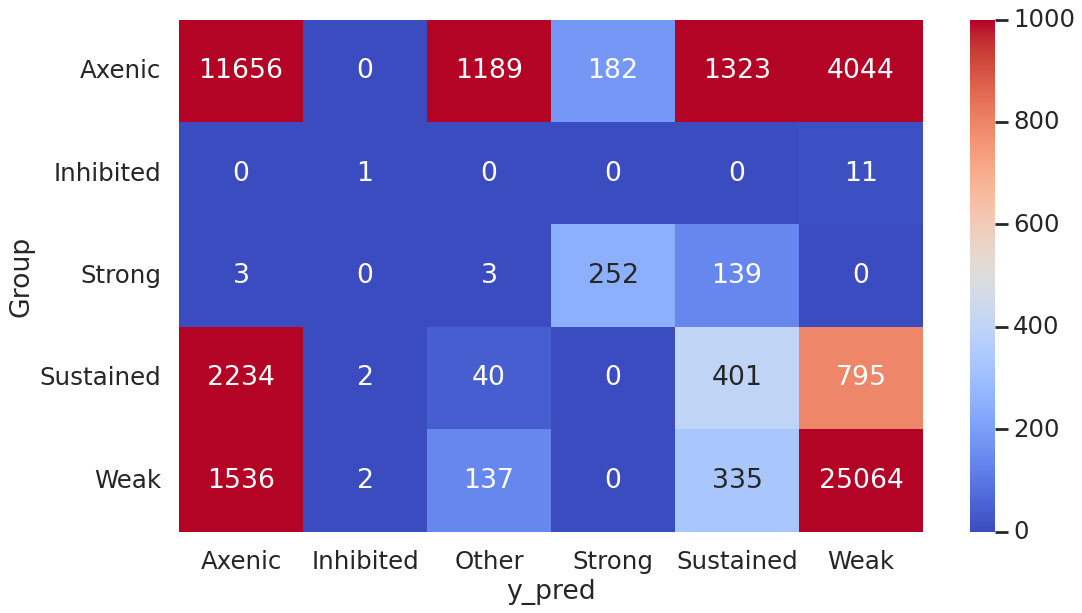

In [31]:
sns.heatmap(
    df[['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').fillna(0).droplevel(0, axis=1),
    cmap='coolwarm', 
    annot=True, fmt='.0f', vmax=1000
)
plt.yticks(rotation=0) 

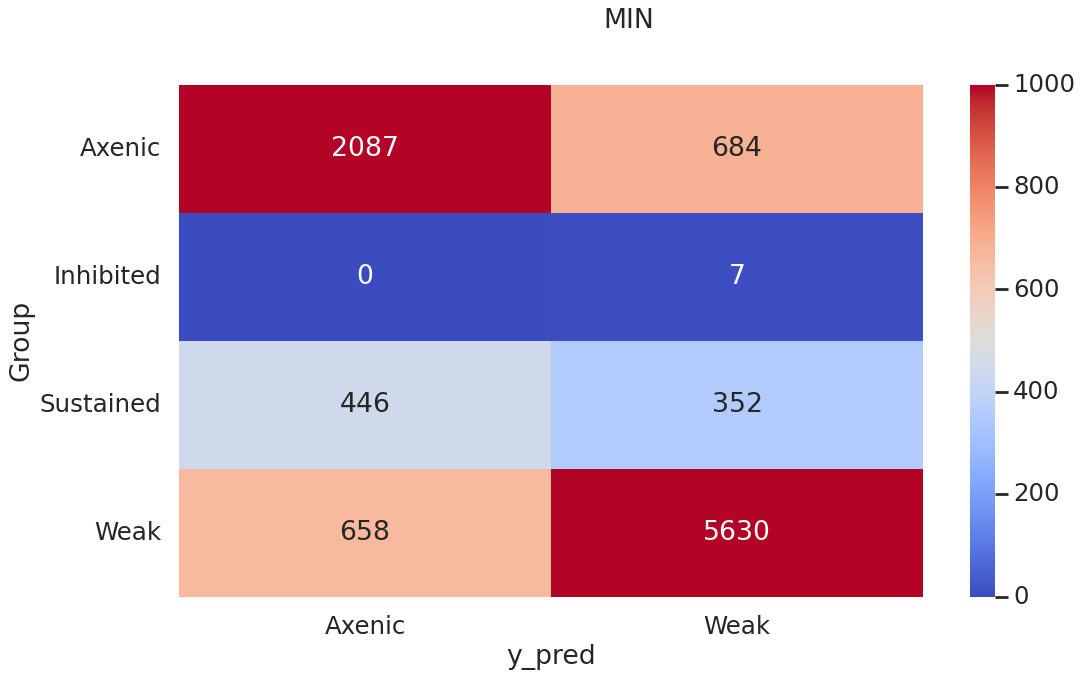

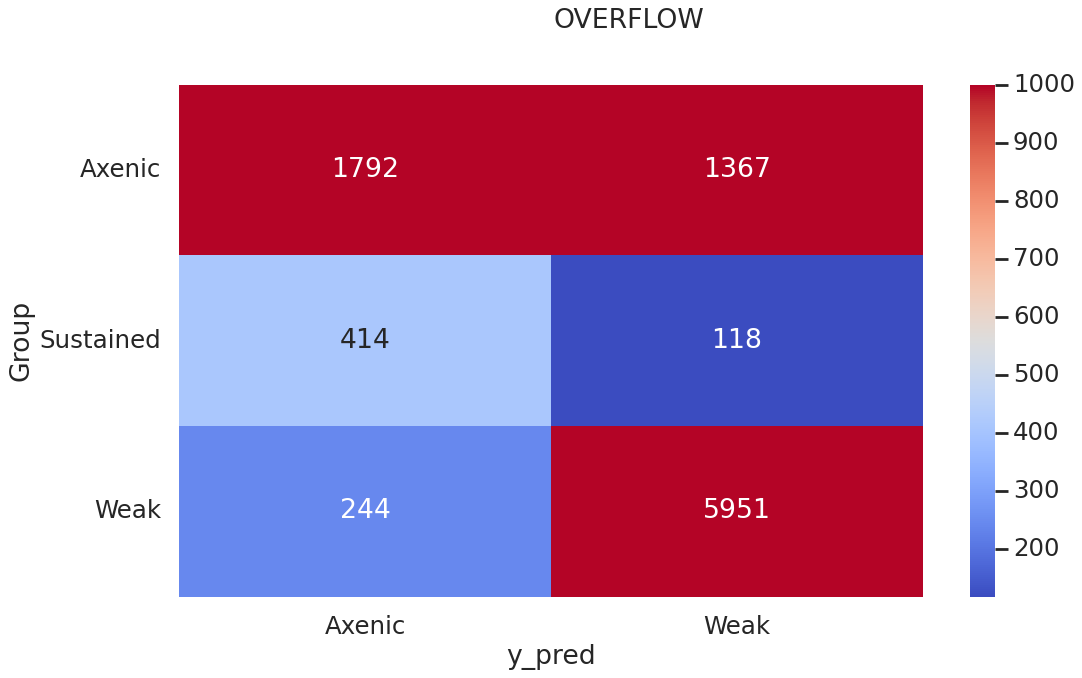

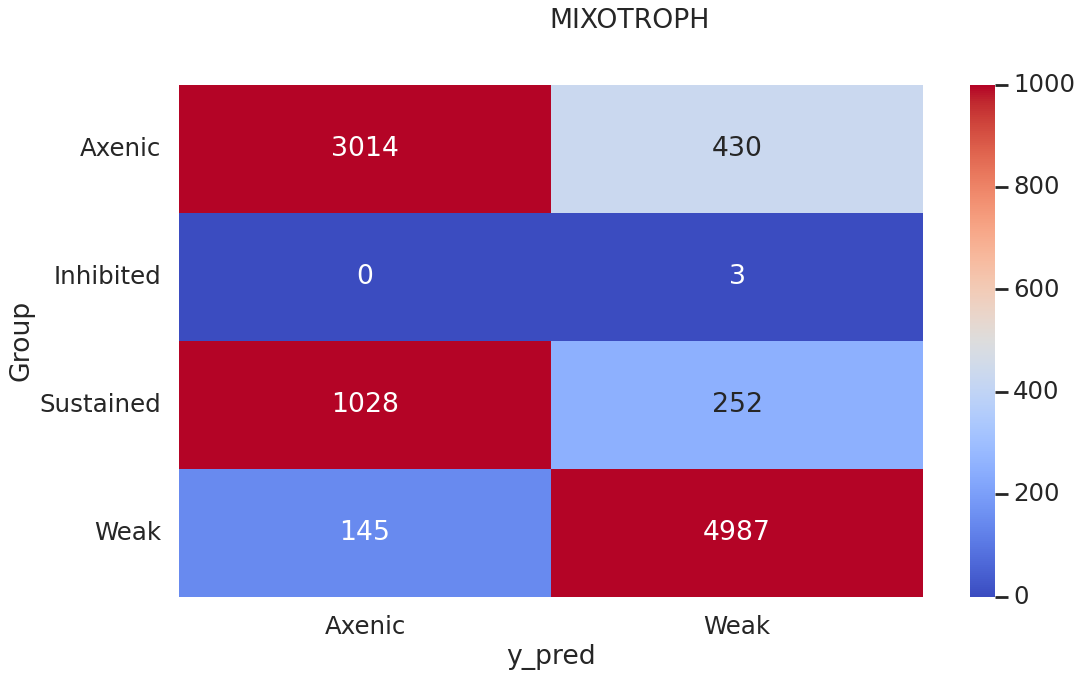

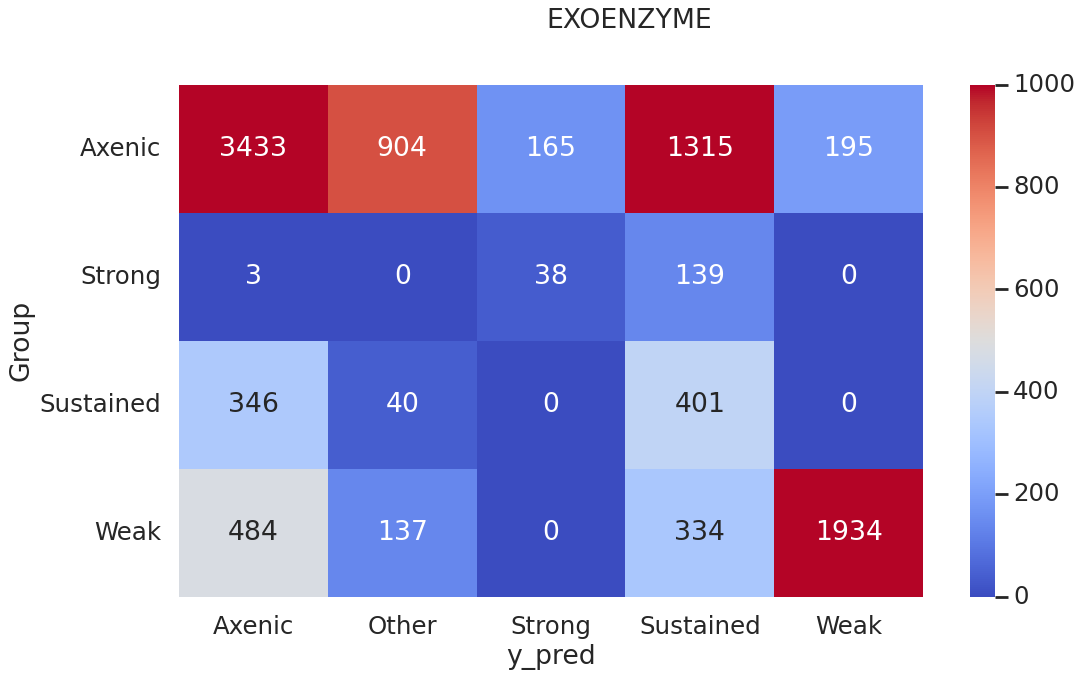

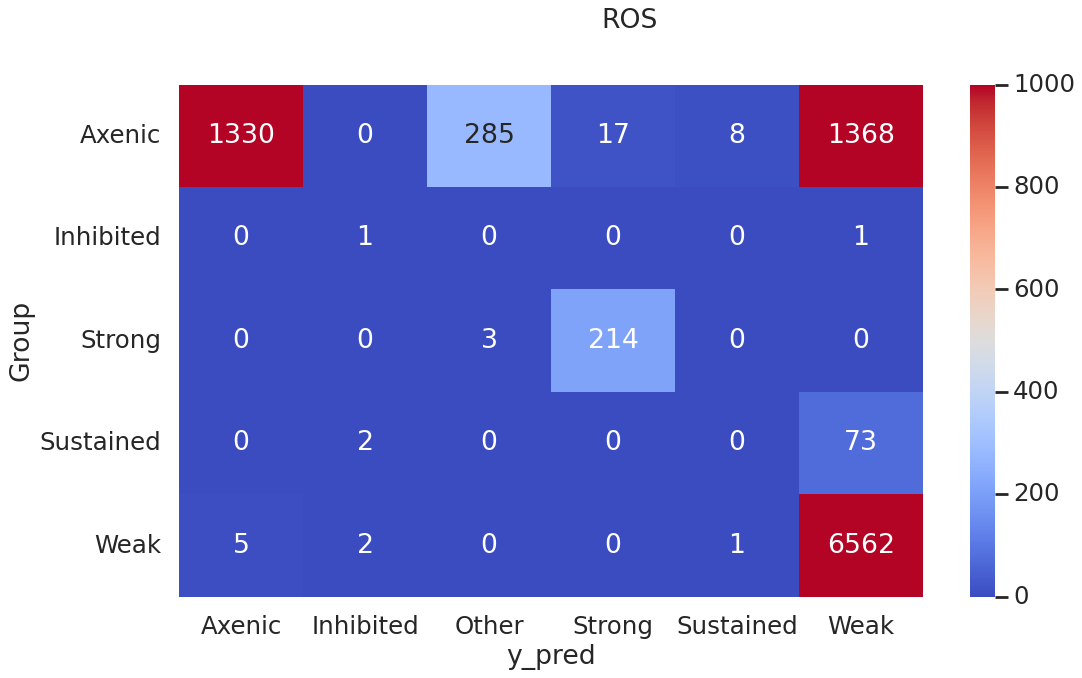

In [32]:
for m in morder:
    sns.heatmap(
        df.loc[df.model.isin([m]),['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').fillna(0).droplevel(0, axis=1),
        cmap='coolwarm', 
        annot=True, fmt='.0f', vmax=1000
    )
    plt.yticks(rotation=0) 
    plt.suptitle(m, y=1.02)
    plt.show()

In [33]:
df[['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').droplevel(0, axis=1).columns


Index(['Axenic', 'Inhibited', 'Other', 'Strong', 'Sustained', 'Weak'], dtype='object', name='y_pred')

In [34]:
df['RMSE_clip'] = df.RMSE.clip(upper=100)

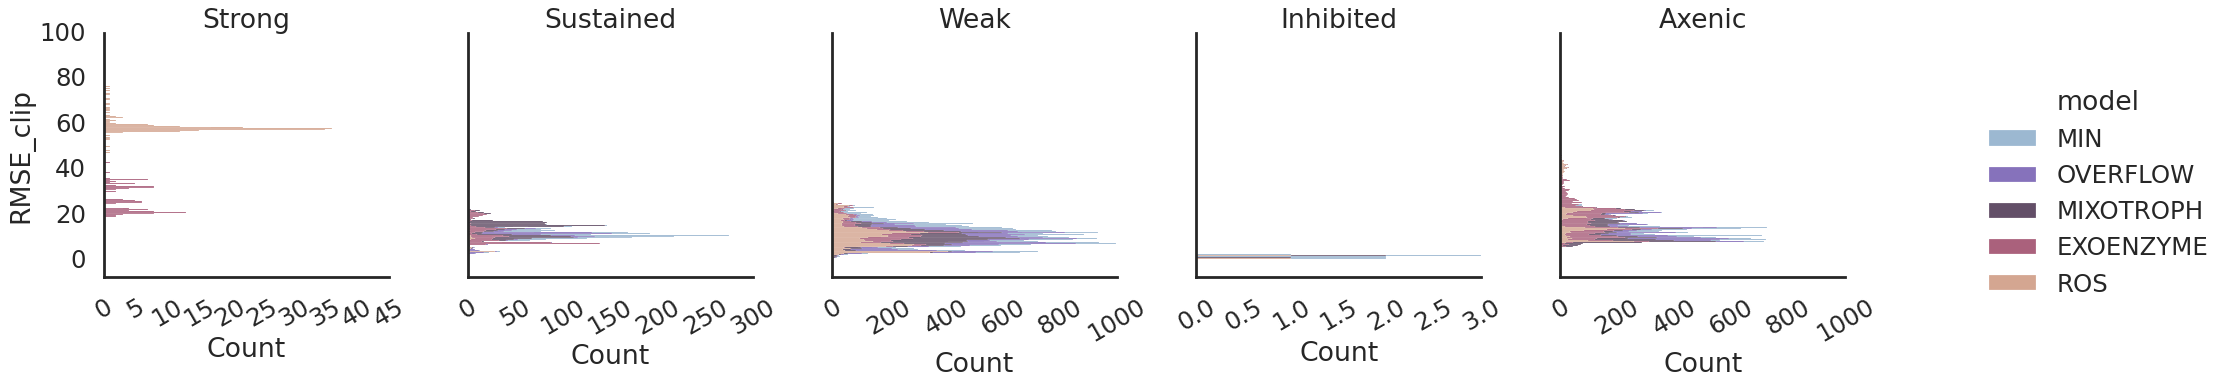

In [35]:
g = sns.displot(
    data=df,
    #col='y_pred', 
    col='Group', col_order=gorder[:-1],
    y='RMSE_clip',
    facet_kws=dict(sharex=False,margin_titles=True),
    #row='model',
    palette=mpalette, hue='model', hue_order=morder, multiple='stack',

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set_xticklabels(rotation=30)
g.set(ylim=(-7,100))
#g.set(yscale='log')

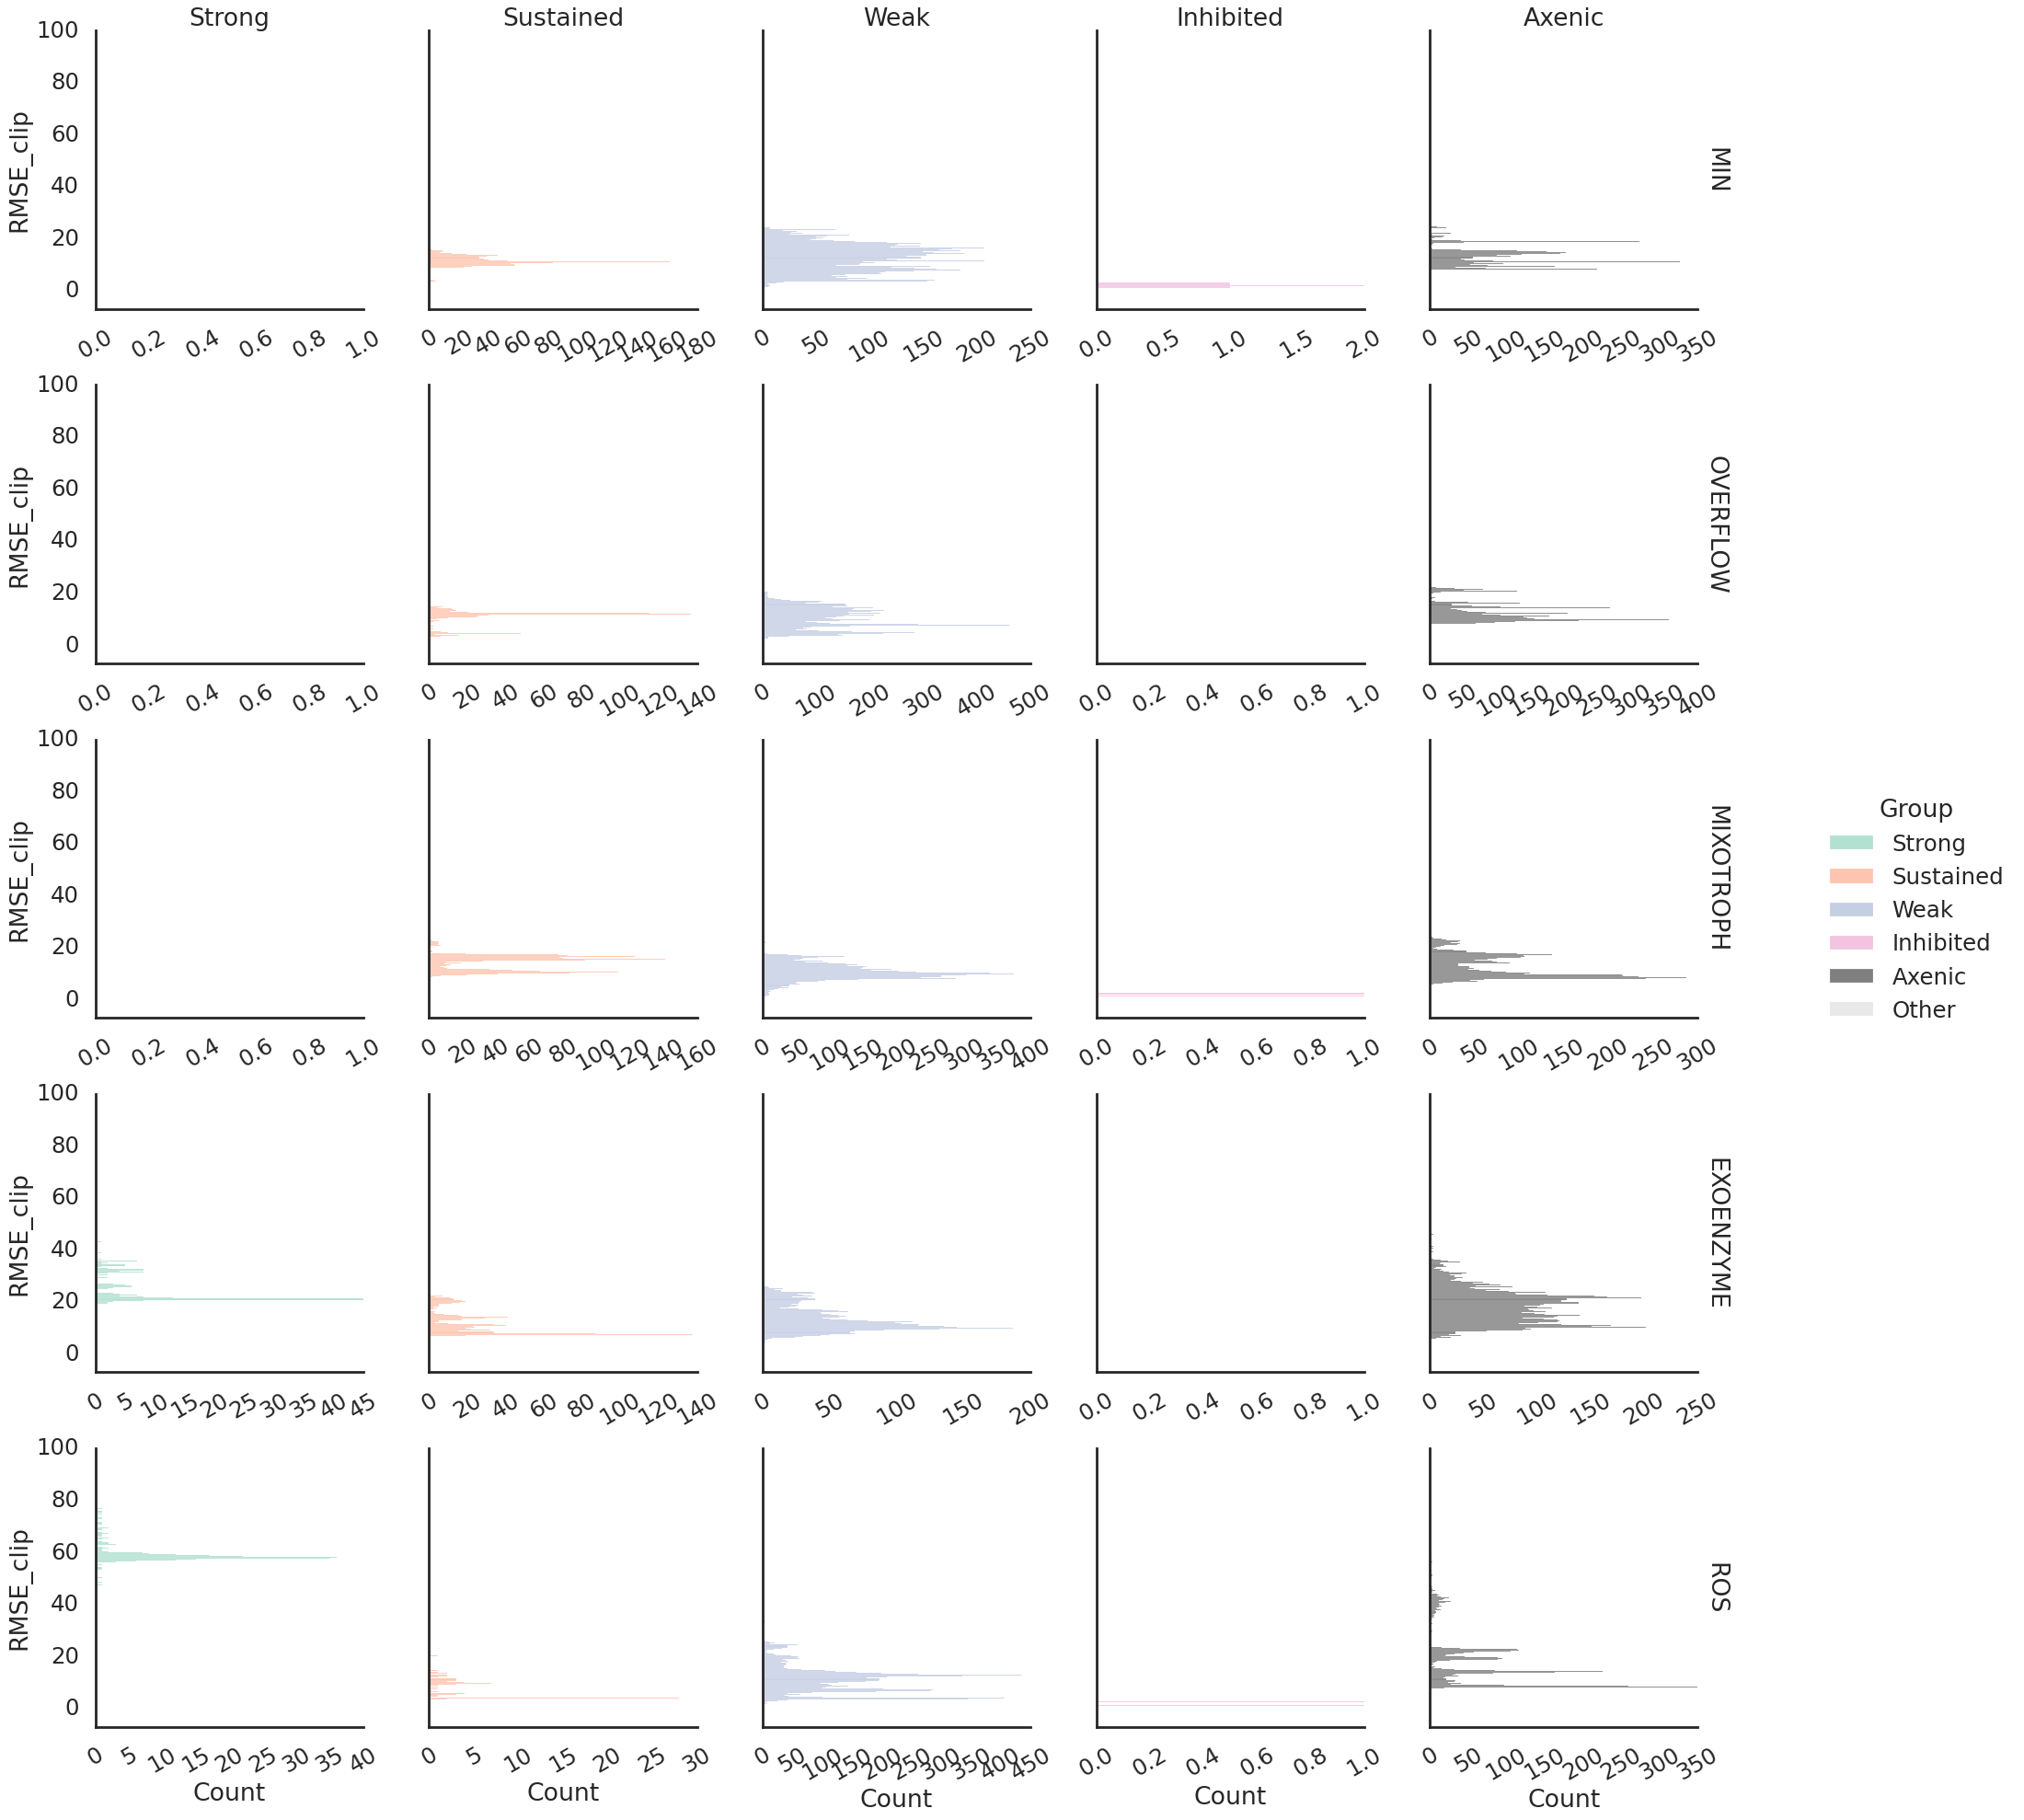

In [36]:
g = sns.displot(
    data=df,
    row='model', row_order=morder, 
    col='Group', col_order=gorder[:-1],
    #palette=mpalette, hue='model', hue_order=morder,
    palette=gpalette, hue='Group', hue_order=gorder,
    
    y='RMSE_clip', #log_scale=True,
    facet_kws=dict(sharex=False, margin_titles=True), #sharey=False,
    #row='model',
    

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(ylim=(-7,100))
g.set_xticklabels(rotation=30)

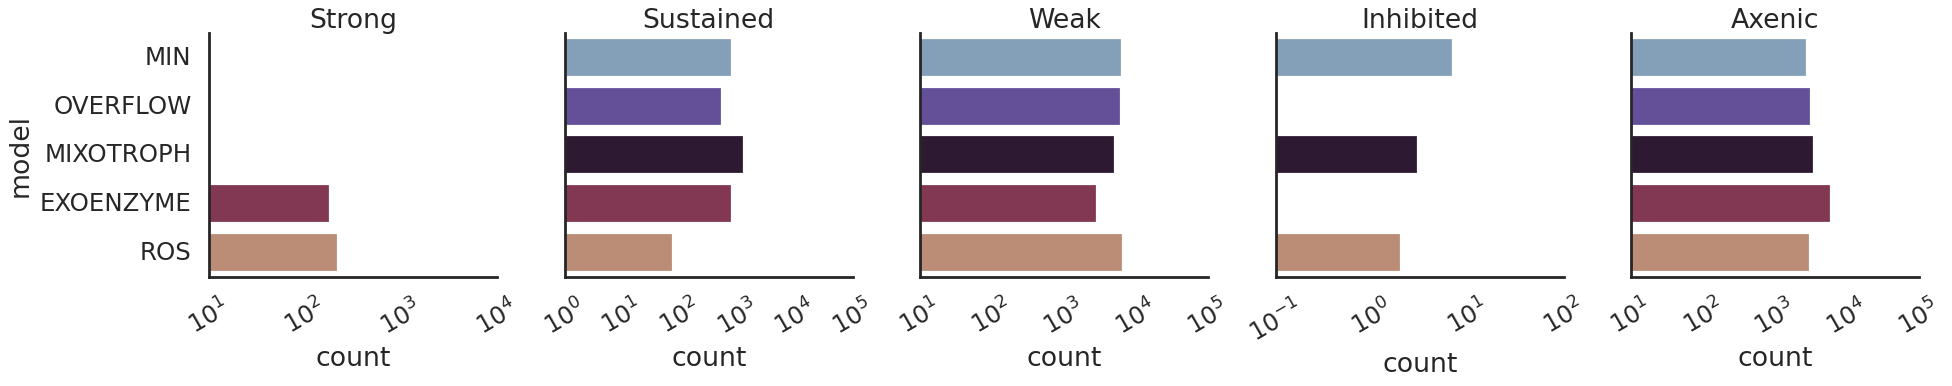

In [37]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
g.set_xticklabels(rotation=30)

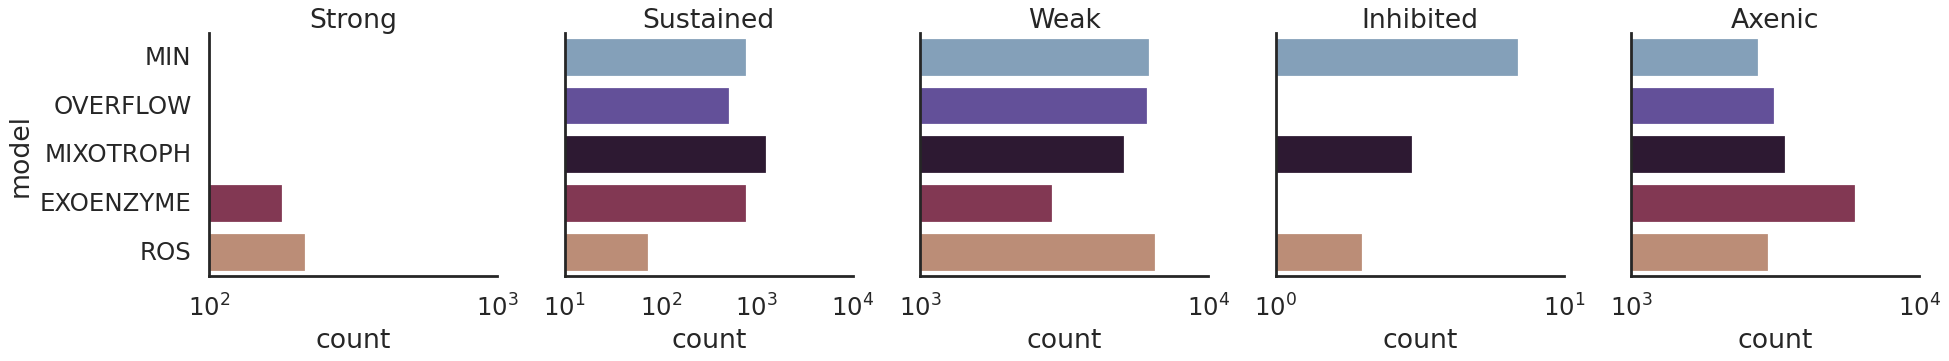

In [38]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
#g.set_xticklabels(rotation=30)

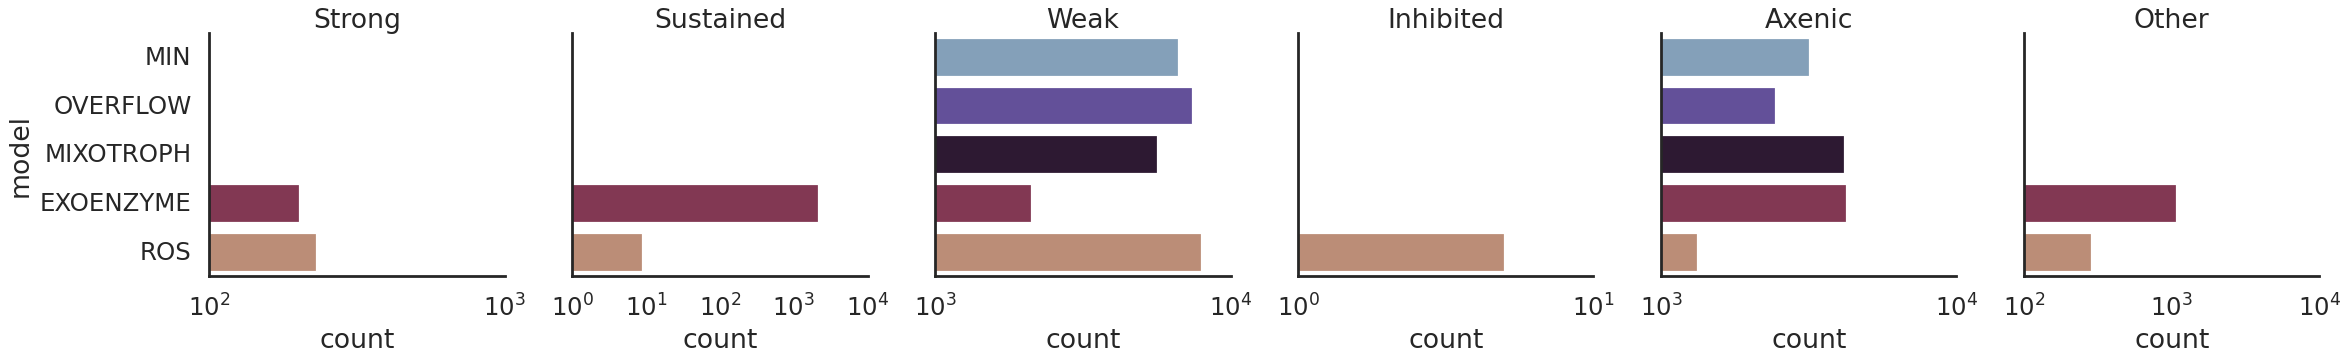

In [39]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='y_pred', col_order=gorder,
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
#g.set_xticklabels(rotation=30)

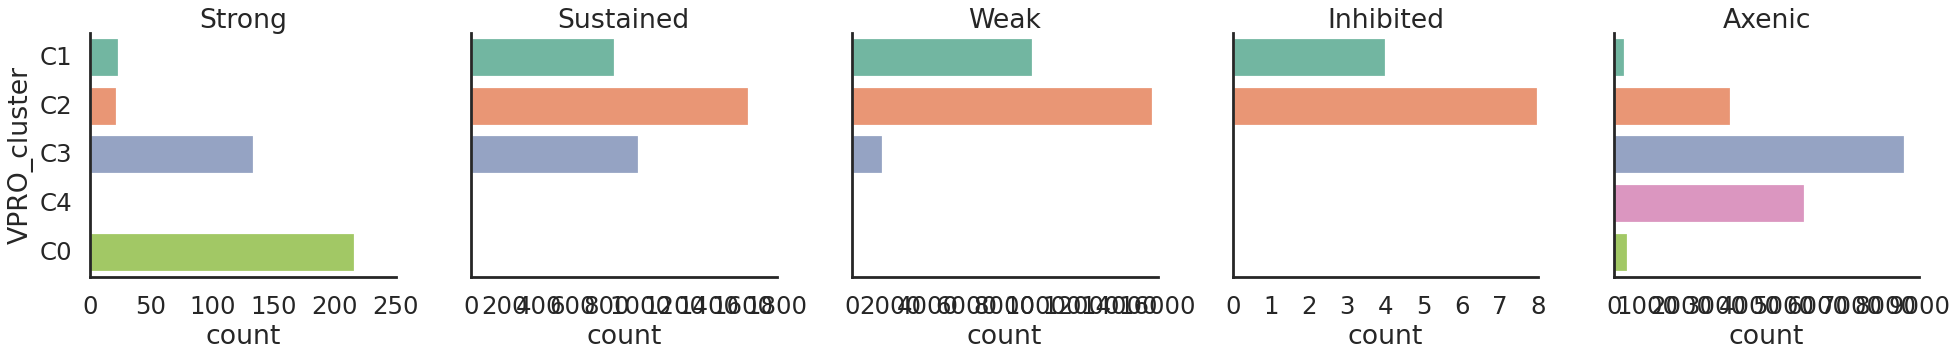

In [40]:
g = sns.catplot(
    data=df,
    y='VPRO_cluster', order=corder, 
    col='Group', col_order=gorder[:-1],
    palette='Set2', hue='VPRO_cluster', hue_order=corder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
#g.set(xscale='log')
#g.set_xticklabels(rotation=30)

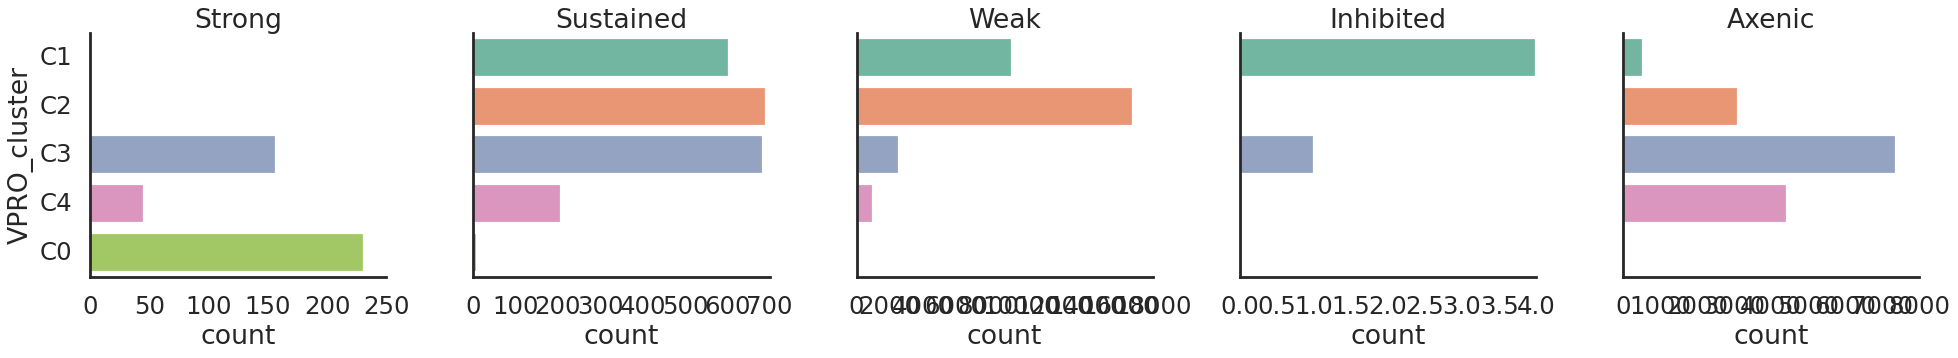

In [57]:
g = sns.catplot(
    data=df,
    y='VPRO_cluster', order=corder, 
    col='y_pred', col_order=gorder[:-1],
    palette='Set2', hue='VPRO_cluster', hue_order=corder, dodge=False,
    kind='count',
    facet_kws=dict(sharex=False, margin_titles=True),
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
#g.set(xscale='log')
#g.set_xticklabels(rotation=30)

In [41]:
df.pivot_table(index='model', columns='Group', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder[:-1])

Group,Strong,Sustained,Weak,Inhibited,Axenic
model,,,,,
MIN,0,798,6288,7,2771
OVERFLOW,0,532,6195,0,3159
MIXOTROPH,0,1280,5132,3,3444
EXOENZYME,180,787,2889,0,6012
ROS,217,75,6570,2,3008


In [60]:
df.pivot_table(index='model', columns='y_pred', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder)

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,0,0,6673,0,3191,0
OVERFLOW,0,0,7436,0,2450,0
MIXOTROPH,0,0,5672,0,4187,0
EXOENZYME,203,2189,2129,0,4266,1081
ROS,231,9,8004,5,1335,288


In [42]:
df.pivot_table(index=['VPRO_cluster'], columns='Group', values='run_id', aggfunc='count', fill_value=0).reindex( columns=gorder[:-1])

Group,Strong,Sustained,Weak,Inhibited,Axenic
VPRO_cluster,,,,,
C0,217,1,43,0,410
C1,24,847,9462,4,322
C2,22,1637,15784,8,3459
C3,134,987,1648,0,8565
C4,0,0,137,0,5638


In [59]:
df.pivot_table(index=['VPRO_cluster'], columns='y_pred', values='run_id', aggfunc='count', fill_value=0).reindex( columns=gorder)

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
VPRO_cluster,,,,,,
C0,231,9,124,0,19,288
C1,0,605,9433,4,539,78
C2,0,691,16778,0,3093,348
C3,157,685,2593,1,7357,541
C4,46,208,986,0,4421,114


In [43]:
df.VPRO_cluster.value_counts()

C2    20910
C3    11334
C1    10659
C4     5775
C0      671
Name: VPRO_cluster, dtype: int64

In [44]:
morder

['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS']

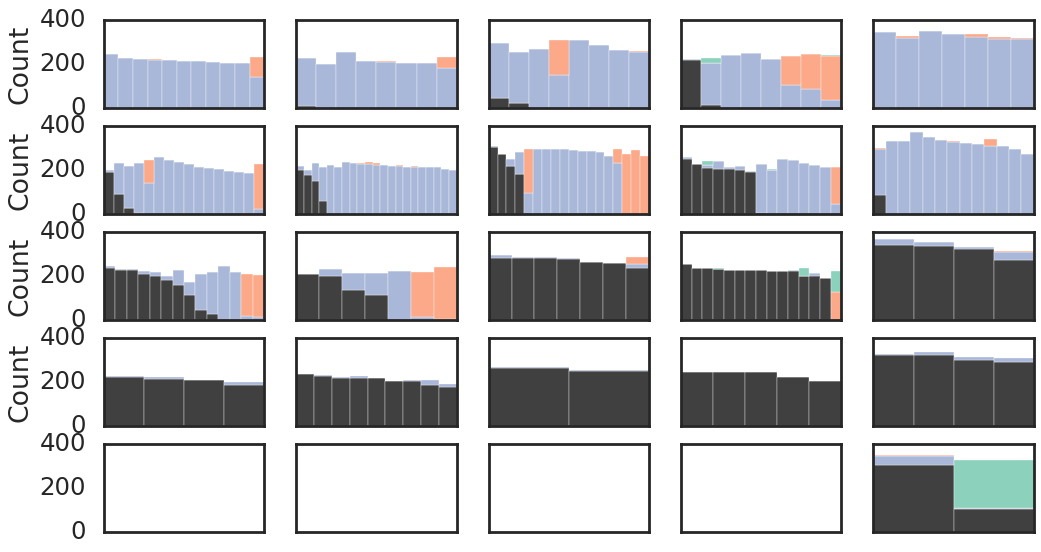

In [45]:
fig, axs = plt.subplots(5, 5, sharey=True)
for i,m in enumerate(morder):
    for j,c in enumerate(['C1', 'C2', 'C3', 'C4', 'C0']):
        t = df.loc[
            df.model.isin([m]) & df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='Group', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=gorder[:-1])
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='Group', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=gorder, palette=gpalette,
                ax=axs[j,i], 
                #aspect=1,
                legend=False,
                       )
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([0,200,400])
        axs[i,j].set_xlabel('')
            
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


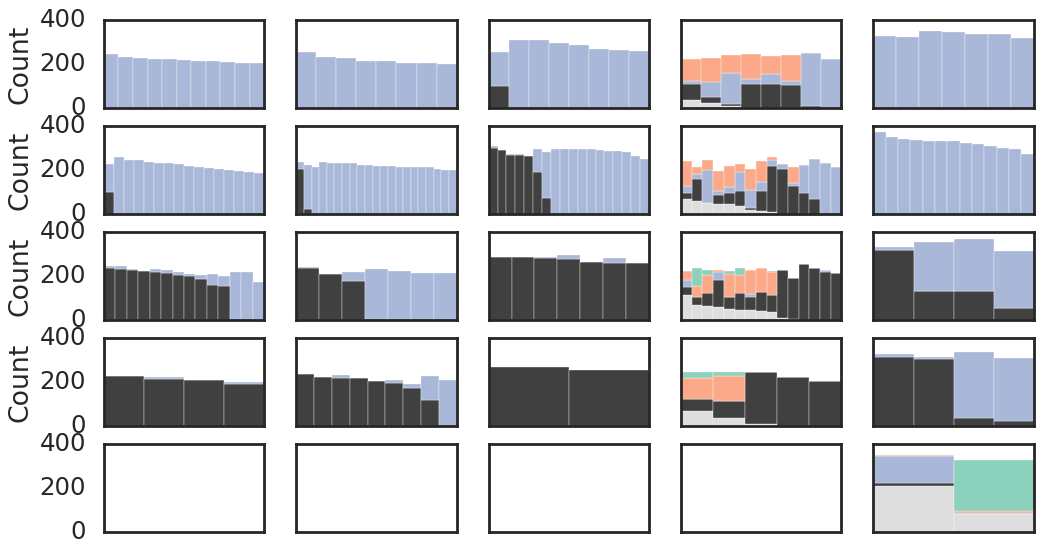

In [46]:
fig, axs = plt.subplots(5, 5, sharey=True)
for i,m in enumerate(morder):
    for j,c in enumerate(['C1', 'C2', 'C3', 'C4', 'C0']):
        t = df.loc[
            df.model.isin([m]) & df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=gorder)
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=gorder, palette=gpalette,
                ax=axs[j,i], 
                #aspect=1,
                legend=False,
                       )
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([0,200,400])
        axs[i,j].set_xlabel('')
            
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


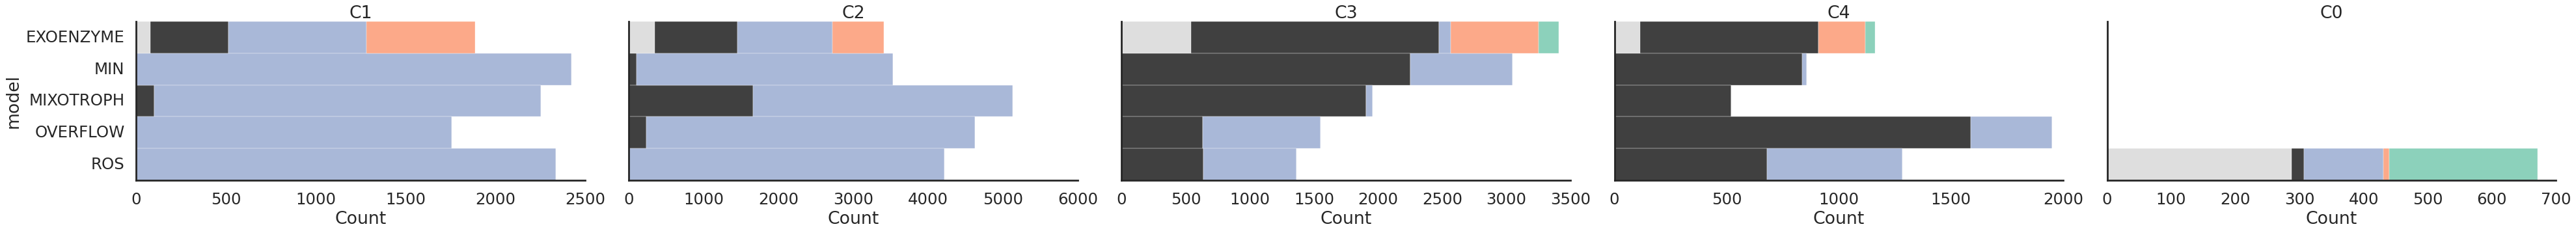

In [109]:
g = sns.displot(
    data=df, lw=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette, #linewidth=1,
    y='model', #col_order='morder',
    col='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    #stat='probability',
    facet_kws=dict(sharex=False),
    aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')


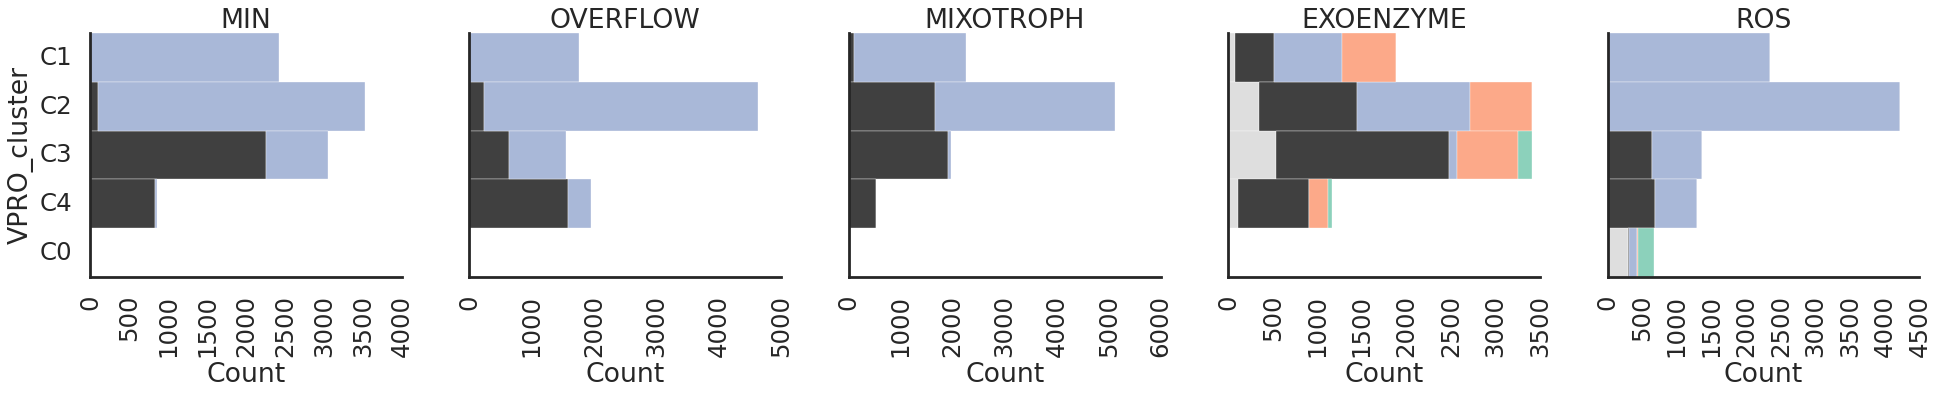

In [112]:
g = sns.displot(
    data=df, linewidth=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette,
    col='model', col_order=morder,
    y='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    #stat='probability',
    facet_kws=dict(sharex=False),
    #aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')
g.set_xticklabels(rotation=90)

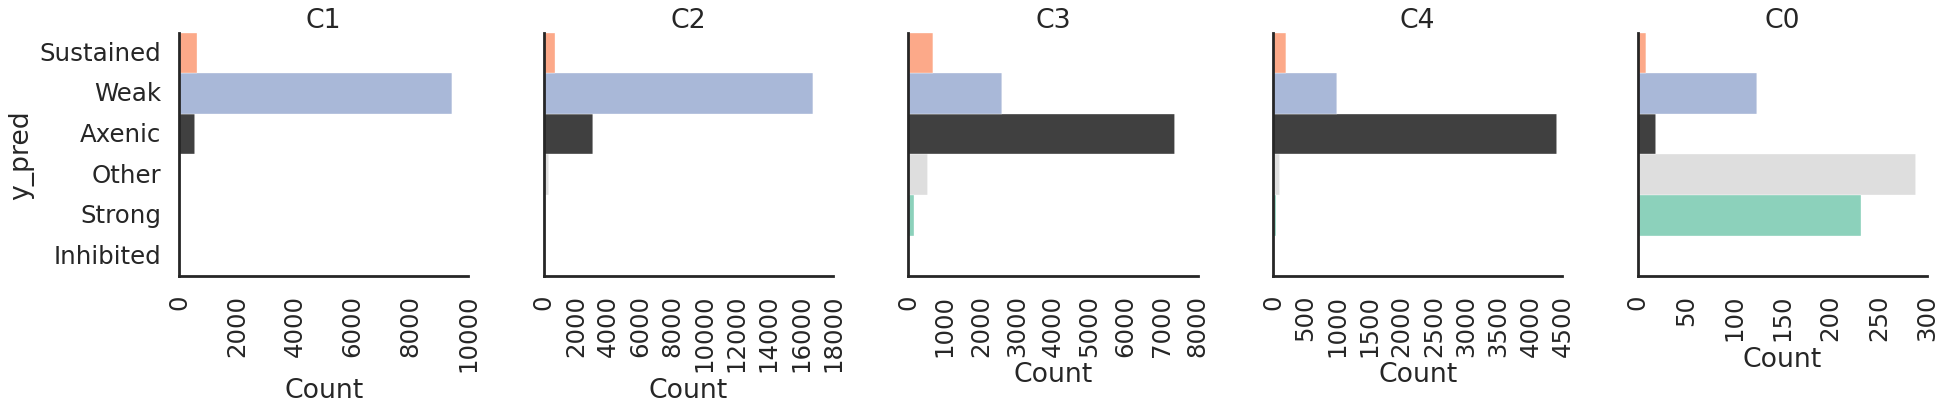

In [104]:
sns.set_context('poster')
g = sns.displot(
    data=df, lw=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette,
    y='y_pred', #dodge=False, #col_order='morder',
    col='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    facet_kws=dict(sharex=False),
    #aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')
g.set_xticklabels(rotation=90)

In [47]:
df.pivot_table(index=['VPRO_cluster'], columns='model', values='VPRO', aggfunc='nunique', fill_value=0).reindex( columns=morder)

model,MIN,OVERFLOW,MIXOTROPH,EXOENZYME,ROS
VPRO_cluster,,,,,
C0,0,0,0,0,2
C1,11,8,8,8,7
C2,16,21,18,15,13
C3,14,7,7,15,4
C4,4,9,2,5,4


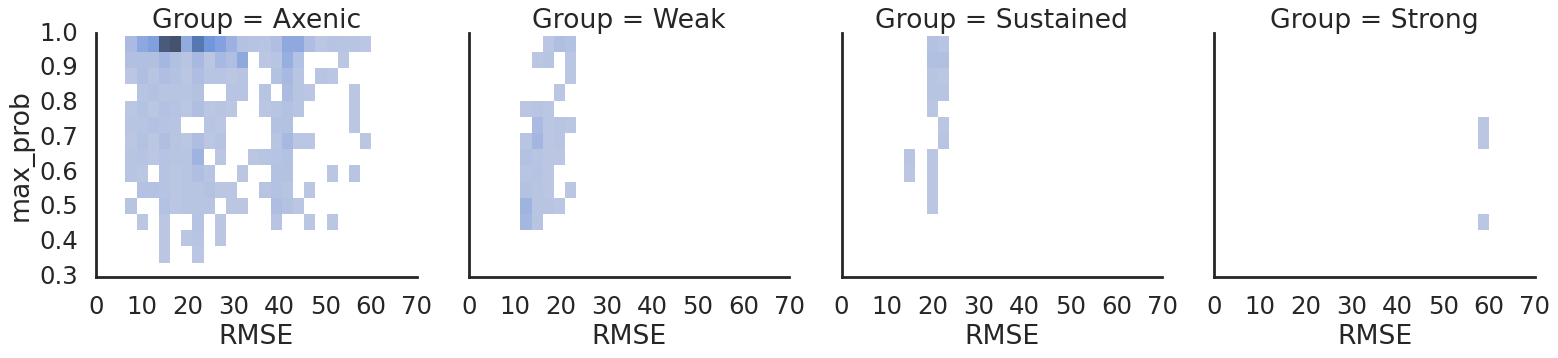

In [71]:
sns.displot(
    data=df.loc[df.y_pred.isin(['Other'])],
    x='RMSE', y='max_prob', col='Group', #col_order=gorder,
)#.set(yscale='log')

In [69]:
df.loc[df.y_pred.isin(['Other'])].groupby(['Group', 'model'])['RMSE'].describe()


count       mean       std        min        25%  \
Group     model                                                         
Axenic    EXOENZYME  904.0  18.693001  6.015919   6.391566  14.589116   
          ROS        285.0  41.917461  4.825218  24.168343  40.142850   
Strong    ROS          3.0  59.470301  0.526435  59.048312  59.175345   
Sustained EXOENZYME   40.0  20.324266  1.836662  14.141770  20.240596   
Weak      EXOENZYME  137.0  15.163762  3.002845  11.412697  12.896135   

                           50%        75%        max  
Group     model                                       
Axenic    EXOENZYME  17.313078  22.649270  39.324842  
          ROS        41.767976  43.393294  58.741261  
Strong    ROS        59.302378  59.681295  60.060213  
Sustained EXOENZYME  20.774716  21.141230  22.271075  
Weak      EXOENZYME  14.422121  16.968344  23.381514

In [49]:
df.loc[df.Group.isin(['Strong','Sustained'])].VPRO.value_counts().nlargest(30)

vpro_97_13_MIXOTROPH_C2    291
vpro_54_14_MIXOTROPH_C2    270
vpro_78_38_MIXOTROPH_C2    263
vpro_84_99_OVERFLOW_C3     235
vpro_93_20_EXOENZYME_C3    223
vpro_19_33_ROS_C0          217
vpro_96_36_MIN_C2          205
vpro_75_20_OVERFLOW_C3     202
vpro_13_69_EXOENZYME_C1    201
vpro_87_65_MIXOTROPH_C2    198
vpro_97_57_MIN_C3          193
vpro_99_36_MIN_C3          191
vpro_61_13_EXOENZYME_C2    169
vpro_50_15_EXOENZYME_C1    159
vpro_100_5_MIXOTROPH_C1    156
vpro_19_83_EXOENZYME_C1    132
vpro_18_48_MIN_C2          104
vpro_64_97_MIN_C1           91
vpro_75_15_MIXOTROPH_C2     64
vpro_44_79_OVERFLOW_C1      53
vpro_77_45_EXOENZYME_C3     37
vpro_78_20_MIXOTROPH_C3     32
vpro_75_35_ROS_C2           30
vpro_58_74_EXOENZYME_C1     23
vpro_75_68_EXOENZYME_C2     17
vpro_23_17_ROS_C1           15
vpro_40_8_OVERFLOW_C2       11
vpro_97_23_ROS_C1            8
vpro_94_22_OVERFLOW_C2       7
vpro_93_82_ROS_C1            7
Name: VPRO, dtype: int64

In [50]:
# get a list of high growth VPROs
VPRO_lst = df.loc[df.Group.isin(['Strong','Sustained']),['model','VPRO']].value_counts().nlargest(30).reset_index()

VPRO_lst = VPRO_lst.rename(columns={0: 'count'})
VPRO_lst = VPRO_lst.loc[VPRO_lst['count'].ge(5)]
VPRO_lst['VPRO'].to_csv('../VPRO/high_growing_vpro.csv', index=False)
VPRO_lst.model.value_counts()
VPRO_lst

,model,VPRO,count
0,MIXOTROPH,vpro_97_13_MIXOTROPH_C2,291
1,MIXOTROPH,vpro_54_14_MIXOTROPH_C2,270
2,MIXOTROPH,vpro_78_38_MIXOTROPH_C2,263
3,OVERFLOW,vpro_84_99_OVERFLOW_C3,235
4,EXOENZYME,vpro_93_20_EXOENZYME_C3,223
5,ROS,vpro_19_33_ROS_C0,217
6,MIN,vpro_96_36_MIN_C2,205
7,OVERFLOW,vpro_75_20_OVERFLOW_C3,202
8,EXOENZYME,vpro_13_69_EXOENZYME_C1,201
9,MIXOTROPH,vpro_87_65_MIXOTROPH_C2,198


In [51]:
for m in morder:
    VPRO_lst.loc[VPRO_lst.model.isin([m]),'VPRO'].to_csv(f'../VPRO/high_growing_vpro_{m}.csv', index=False, header=False)
    

In [52]:
df = df.drop(columns=['Unnamed: 0'])

In [53]:
df.columns

Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
       'hash', 'Sample', 'full name', 'Group', 'RMSE_Bptotal[N]',
       'RMSE_Bptotal[C]', 'compare_points', 'RMSE', 'VPRO', 'VPRO_cluster',
       'RMSE_clip'],
      dtype='object')

In [54]:
df.to_csv('../results/monte_het_minmse.csv.gz', index=False)

In [55]:
stop

NameError: name 'stop' is not defined

In [ ]:
df.RMSE.describe()

In [ ]:
df['Group'].value_counts(), df['y_pred'].value_counts()


In [ ]:
df.run_id.str.split('_', expand=True)[0].value_counts()

In [ ]:
df_predicted_classes

In [ ]:
df_predicted_classes['VPRO'] = df_predicted_classes.run_id.str.replace(
    r'.*_monte.?_','', regex=True).str.replace(
    r'_\d*_lowN_all.*', '', regex=True)

In [ ]:
df_predicted_classes.groupby('model').VPRO.nunique()

In [ ]:
number_of_predictions = df_predicted_classes.pivot_table(index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0).reindex(columns=gorder).sort_values(by=gorder)

In [ ]:
df_predicted_classes.pivot_table(index='model', columns='y_pred', values='VPRO', aggfunc='count', fill_value=0).reindex(columns=gorder, index=morder)

In [ ]:
plt.showow()

In [ ]:
df_predicted_classes.groupby('model')['VPRO'].nunique()

In [ ]:
df_predicted_classes.pivot_table(index='model', columns='y_pred', values='VPRO', aggfunc='nunique', fill_value=0).reindex(columns=gorder, index=morder)

In [ ]:
for m in morder:
    t = df_predicted_classes.loc[
        df_predicted_classes.model.isin([m]) & 
        df_predicted_classes.y_pred.isin([ 'Sustained','Strong', 'Inhibited', ])
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=[ 'Inhibited','Strong','Sustained',  ])
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
        g = sns.displot(
            data=t,
            hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
            hue_order=gorder, palette=gpalette,
            aspect=2,
                   )
        g.set(xticklabels=[])
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.title(m)


In [ ]:
for m in morder:
    t = df_predicted_classes.loc[
        df_predicted_classes.model.isin([m]) #& 
        #df_predicted_classes.y_pred.isin([ 'Sustained','Strong', 'Inhibited', ])
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=gorder)
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], tnumdf.index)
        g = sns.displot(
            data=t,
            hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
            hue_order=gorder, palette=gpalette,
            aspect=2,
            legend=False,
                   )
        
        g.set(xticklabels=[], xlabel='VPRO')
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.title(m)
